In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import *

# Initial Class Definitions

In [37]:
# implements the basic features of our creatures.
# they are:
#    > gender (init=distribution)
#    > alive (init=true)
#    > age (init=distr or 0)
#    > offspring (init=0)
#    > fertility (init=distr)
class Creature:
    universe = None
    
    def __init__(self, gen, age=0):
        self.gender = 'm' if (np.random.uniform() < self.universe.mf_ratio[type(self)]) else 'f'
        self.fertility = True if (np.random.uniform() < self.universe.fertility_ratio[type(self)]) else False
        self.age = age
        self.generation = gen
        self.alive = True
        self.offspring = 0
    
    def is_adult(self):
        return self.age >= self.universe.adult_age[type(self)]
    
    def can_procriate(self):
        return ((self.gender == 'f') and self.fertility)
    
    def children(self, gen):
        ncs = max([1, int(np.round(np.random.normal(loc=self.universe.offspring_mean[type(self)],
                                                    scale=self.universe.offspring_variance[type(self)])))])
        return [type(self)(gen=gen, age=0) for i in range(ncs)]
    
    def increment_age(self):
        self.age = self.age + 1
    
    def kill(self):
        self.alive = False

    
    # checks if the creature died randomly. If it did,
    # updates its 'alive' attribute.
    #
    # returns if a random death occured (True) or not (False)
    def random_death(self):
        if (np.random.uniform(low=0.0, high=1.0) < self.universe.random_death_chance[type(self)]):
            self.alive = False
            return True
        else:
            return False

        
    # checks if an old death occured. If it occured, updates
    # the 'alive' attribute of the creature.
    #
    # returns if an old age death actually occured (True) or
    # not (False)
    def old_age_death(self):
        if (self.age > self.universe.lifespan[type(self)]):
            self.alive = False
            return True
        else:
            return False
    

# implements fly-only features and conditions
# <<< this one's the predator/parasite
class Fly(Creature):
    pass

# implements moth-only features and conditions
class Moth(Creature):
    caterpillars = []
    
    def __init__(self, gen, age=0):
        self.gender = 'm' if (np.random.uniform() < self.universe.mf_ratio[type(self)]) else 'f'
        self.fertility = True if (np.random.uniform() < self.universe.fertility_ratio[type(self)]) else False
        self.age = age
        self.generation = gen
        self.alive = True
        self.offspring = 0
        
        if self.is_caterpillar():
            self.caterpillars.append(self)
    
    def is_caterpillar(self):
        return ((self.universe.egg_age[type(self)] < self.age) and
                (self.age < self.universe.adult_age[type(self)]))
    
    def increment_age(self):
        was_caterpillar = self.is_caterpillar()
        self.age = self.age + 1
        now_is_caterpillar = self.is_caterpillar()
        
        # was, but now its too old and it isn't anymore
        if was_caterpillar and not now_is_caterpillar:
            self.caterpillars.remove(self)
        
        # wasn't, but got older and achieve legal caterpillar age
        if not was_caterpillar and now_is_caterpillar:
            self.caterpillars.append(self)
            
        # if it was and still is, do nothing
        # if it wasn't and still isn't, also do nothing

    def kill(self):
        self.alive = False
        if self.is_caterpillar():
            self.caterpillars.remove(self)
            

# set of biological laws that our system obeys,
# amongst which:
#    > distributions between male and female gender of each creature
#    > lifespan of each creature
#    > initial lifespan distribution for each creature
#    > fertility ratio for each creature
#    > offspring mean and variance (normal distributions predefined for
#      these distributions)
class Universe:
    def __init__(self, fmfr, flfsp, ffr, fom, fov, faa, frd,  # fly parameters
                 mmfr, mlfsp, mfr, mom, mov, maa, mea, mrd,   # moth parameters
                 predation_coefficient):                      # other parameters
        
        self.mf_ratio = {Fly: fmfr, Moth: mmfr}
        self.lifespan = {Fly: flfsp, Moth: mlfsp}
        self.fertility_ratio = {Fly: ffr, Moth: mfr}
        self.offspring_mean = {Fly: fom, Moth: mom}
        self.offspring_variance = {Fly: fov, Moth: mov}
        self.adult_age = {Fly: faa, Moth: maa}
        self.egg_age = {Fly: None, Moth: mea}
        self.random_death_chance = {Fly: frd, Moth: mrd}
        
        self.predation_coefficient = predation_coefficient
        
        self.recordable_data = ['living',
                                'dead',
                                'male',
                                'female',
                                'randomly_killed',
                                'old_age_killed',
                                'parents',
                                'newborn',
                                'predation'
                               ]
        self.c_types = ['moth-', 'fly-']
        self.df_colums = [(c + d) for c, d in product(self.c_types, self.recordable_data)]
    
class WonderfulWorld:
    
    def __init__(self, n_moths, n_flies, universe):
        self.universe = universe
        Creature.universe = universe
        self.instant = 0
          
        self.n_moths = n_moths
        self.n_flies = n_flies
            
        self.creatures = {Moth: [], Fly: []}
        self.data_log = pd.DataFrame(data=None, index=None, columns=self.universe.df_colums)
        
    
    # initializes the world with the random distributions of moths and flies
    def initialize_world(self):
        self.instant = 0
        
        # reset the list of caterpillars, if it wasn't already empty
        del Moth.caterpillars[:]
        
        # initializes:
        #    - ages based on a uniform distribution
        #    - genders following the universe's male/female ratios
        self.creatures = {
            Moth: [Moth(0, age=np.random.randint(low=0, high=self.universe.lifespan[Moth] + 1)) 
                    for i in range(self.n_moths)],
            Fly: [Fly(0, age=np.random.randint(low=0, high=self.universe.lifespan[Fly] + 1)) 
                   for i in range(self.n_flies)]
        }
        
        self.reset_iteration_log()
    
    

    def kill_creature(self, creature):
        creature.kill()
        self.creatures[type(creature)].remove(creature)
        
    
    def procriate(self, creature):
        children = creature.children(gen=(self.instant + 1))
        self.creatures[type(creature)] += children
        
        self.iteration_data[type(creature)]['parents'] += 1
        self.iteration_data[type(creature)]['newborn'] += len(children)
    
    def random_death(self, creature):
        if creature.random_death():
            self.iteration_data[type(creature)]['randomly_killed'] += 1
            self.kill_creature(creature)
            return True
        else:
            return False
    
    def old_age_death(self, creature):
        if creature.old_age_death():
            self.iteration_data[type(creature)]['old_age_killed'] += 1
            self.kill_creature(creature)
            return True
        else:
            return False
    
    # calculates the chances of a predation happening. Idea: use
    # the ratio caterpillars/flies instead of the moth/flies ratio,
    # since only the caterpillars can be infested
    def predation_happens(self):
        # chance of happening: coeff * n_caterpillars / n_flies
        if self.creatures[Fly]:
            return np.random.uniform() < (self.universe.predation_coefficient *
                                          len(Moth.caterpillars) / len(self.creatures[Fly]))
        else:
            return False
    
    def single_step(self):
        # moth stuff:
        #    > see if it died randomly
        #    > see if died of old age
        #        - if it was female and fertile, procriates on death
        #    > nothing happens bean stew (increment age)
        #    > check if it's a caterpillar now (not necessary)
        #
        # >>> how to process moths from older generations??
        #     - copy the moths on the new generation list? (nah)
        #     - go checking through all generations the living moths
        #     - and process them (nah)
        #     - implement a generator method living_moths() that returns
        #       the indexes of only the living moths and iterate on that
        #       (oya)
        #
        # IMPORTANT OBS: WE DO NOT PROCESS THE NEWBORN CREATURES
        # ON THE SAME LOOP, ONLY ON THE NEXT ONE (even tho it would
        # be easy to include them, it would suffice to set the upper
        # limit on the living_creatures() generator as 'instant + 2')
        #
        self.reset_iteration_log()
        
        for moth in self.creatures[Moth]:
            if not self.random_death(moth):
                if self.old_age_death(moth):
                    if moth.can_procriate():
                        self.procriate(moth)
                else:
                    moth.increment_age()
            self.log_creature(moth)
        
        # fly stuff:
        #    > random death
        #    > death by old age
        #        - with its last breath, it parasited a moth
        #          (or not, we roll the dice to check)
        #    > nothing happens bean stew (increment age)
        for fly in self.creatures[Fly]:
            if not self.random_death(fly):
                if self.old_age_death(fly):
                    if fly.can_procriate():
                        if self.predation_happens():
                            self.predation(fly)
                else:
                    fly.increment_age()
            self.log_creature(fly)
        
        self.save_iteration_log()
        self.instant = self.instant + 1
        
    # save the useful data on a dataframe for each generation
    # self.recordable_data = ['living',
    #                         'dead',
    #                            'male',
    #                            'female',
    #                            'randomly_killed',
    #                            'old_age_killed',
    #                            'parents',
    #                            'newborn',
    #                            'predators'
    #                           ]
    def log_creature(self, creature):
        self.iteration_data[type(creature)]['living'] += creature.alive
        self.iteration_data[type(creature)]['dead'] += not creature.alive
        self.iteration_data[type(creature)]['male'] += creature.gender == 'm'
        self.iteration_data[type(creature)]['female'] += creature.gender == 'f'
    
    def reset_iteration_log(self):
        self.iteration_data = {
            Moth: dict.fromkeys(self.universe.recordable_data, 0),
            Fly: dict.fromkeys(self.universe.recordable_data, 0)
        }
    
    def save_iteration_log(self):
        self.data_log = self.data_log.append(pd.DataFrame(data=[list(self.iteration_data[Moth].values()) +
                                                                list(self.iteration_data[Fly].values())],
                                                          index=[len(self.data_log)],
                                                          columns=self.universe.df_colums))

    
    # predation method
    #     > everything already settle
    #     > fly already dieded
    #     > check to see if predation happens already made
    #       and returned a green light
    def predation(self, fly):
        self.iteration_data[Fly]['predation'] += 1
        self.iteration_data[Moth]['dead'] += 1
        
        # some shit happens
        # get the lucky bastard (caterpillars) by its horns 
        # (index on the living caterpillars)
        lucky_caterpillar = Moth.caterpillars[np.random.randint(low=0, high=len(Moth.caterpillars))]
        
        # kill 'em
        self.kill_creature(lucky_caterpillar)
        
        # new baby flies are born
        # OBS::: WE DONT CHECK IF THE FLY IS FEMALE
        self.procriate(fly)
    
    
    # runs the world with a given number of steps 'end_of_times'
    def run_world(self, end_of_times):
        
        self.initialize_world()
        for i in range(end_of_times):
            #print('iteration {}'.format(i))
            self.single_step()
        
        return self.data_log



In [38]:
# beetle universe laws:
#     - male/female ratio (mfr)
#     - lifespan (lfsp)
#     - fertility ratio (fr)
#     - offspring mean and variance (om and ov)
#     - adult age (aa, equal or higher is adult)
#     - egg age (ea, less or equal is egg)
#     - random death (chance)
# fly universe laws parameters
fly_params = {
                'mfr': 0.5,
                'lfsp': 20,
                'fr': 0.5,
                'om': 20,
                'ov': 5,
                'aa': 10,
                'rd': 0.05
            }

# moth universe laws parameters
moth_params = {
                'mfr': 0.5,
                'lfsp': 20,
                'fr': 0.5,
                'om': 6,
                'ov': 2,
                'aa': 10,
                'ee': 5,
                'rd': 0.05
              }

# other parameters:
#     - predation coefficient (pc)
other_params = {
                'pc': 1.0
}

In [39]:
# universe laws definition
u = Universe(*fly_params.values(), *moth_params.values(), *other_params.values())

# initial number of beetles and wasps
nm = 100
nf = 100

# number of simulation steps
steps = 200

# world definition
np.random.seed(42)
w = WonderfulWorld(nm, nf, u)
df = w.run_world(steps)

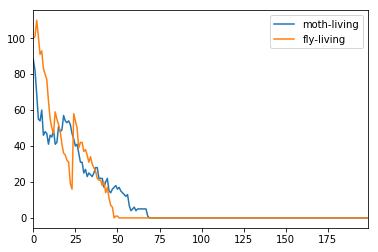

In [40]:
df[['moth-living', 'fly-living']].plot()
plt.show()

In [139]:
w.single_step()
w.instant

1

In [6]:
w.data_log

,moth-living,moth-dead,moth-male,moth-female,moth-randomly_killed,moth-old_age_killed,moth-parents,moth-newborn,moth-predation,fly-living,fly-dead,fly-male,fly-female,fly-randomly_killed,fly-old_age_killed,fly-parents,fly-newborn,fly-predation
0,88,6,48,46,6,0,0,0,0,100,0,53,47,0,0,0,0,0
1,82,7,47,41,3,3,0,0,0,101,11,55,57,7,4,1,23,1
2,69,10,43,35,6,3,0,0,0,110,12,56,66,8,4,1,22,1
3,55,11,35,31,6,5,0,0,0,101,11,51,61,5,6,0,0,0
4,54,6,31,29,4,2,0,0,0,91,10,49,52,6,4,0,0,0
5,60,0,32,28,0,0,0,0,0,93,4,44,53,2,2,0,0,0
6,46,7,29,24,5,2,0,0,0,83,7,40,50,4,3,0,0,0
7,65,8,39,34,5,3,1,28,0,84,3,39,48,2,1,0,0,0
8,65,4,33,36,1,3,0,0,0,69,9,35,43,6,3,0,0,0
9,57,6,30,33,4,2,0,0,0,66,6,30,42,4,2,0,0,0


In [159]:
w.instant

0

In [270]:
w.moths[0][0].age
ages = [m.can_procriate() for m in w.flies[0]]

In [301]:
w.living_creatures_idx

{__main__.Moth: [(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9),
  (0, 10),
  (0, 11),
  (0, 12),
  (0, 13),
  (0, 14),
  (0, 15),
  (0, 16),
  (0, 17),
  (0, 18),
  (0, 19),
  (0, 20),
  (0, 21),
  (0, 22),
  (0, 23),
  (0, 24),
  (0, 25),
  (0, 26),
  (0, 27),
  (0, 28),
  (0, 29),
  (0, 30),
  (0, 31),
  (0, 32),
  (0, 33),
  (0, 34),
  (0, 35),
  (0, 36),
  (0, 37),
  (0, 38),
  (0, 39),
  (0, 40),
  (0, 41),
  (0, 42),
  (0, 43),
  (0, 44),
  (0, 45),
  (0, 46),
  (0, 47),
  (0, 48),
  (0, 49),
  (0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58),
  (0, 59),
  (0, 60),
  (0, 61),
  (0, 62),
  (0, 63),
  (0, 64),
  (0, 65),
  (0, 66),
  (0, 67),
  (0, 68),
  (0, 69),
  (0, 70),
  (0, 71),
  (0, 72),
  (0, 73),
  (0, 74),
  (0, 75),
  (0, 76),
  (0, 77),
  (0, 78),
  (0, 79),
  (0, 80),
  (0, 81),
  (0, 82),
  (0, 83),
  (0, 84),
  (0, 85),
  (0, 86),
  (0, 87),
  (0, 88),
  (0, 89),
  (0,

In [303]:
#for m in w.moths[0]:
#    print(m.age)
print(len(w.moths[0]))

200


In [13]:
# number of creatures
# lifespan
# initial lifespan distr
# gender distr
# 

In [9]:
b = [0,0]

In [41]:
np.random.uniform() < 0.5

True

In [57]:
a = [(0,i) for i in range(5)]

In [62]:
a

[(0, 0), (0, 1), (0, 4)]

In [61]:
for idx,elem in enumerate(a):
    print(elem)
    if idx == 2:
        del a[idx]

(0, 0)
(0, 1)
(0, 3)


In [25]:
del a[0][2]

In [174]:
a = (0,2)

In [175]:
def foo(a, b):
    return a + b


In [176]:
foo(a[0], a[1])

2

In [178]:
foo(*a)

2

In [16]:
c = ['living_moths',
     'female_living_moths',
     'dead_moths',
     'randomly_killed_moths',
     'old_age_dead_moths', 
     'newborn_moths',
     'living_flies',
     'female_living_flies',
     'dead_flies',
     'randomly_killed_flies',
     'old_age_dead_flies',
     'actual_predator_flies',
     'newborn_flies'
     ]

In [17]:
c

['living_moths',
 'female_living_moths',
 'dead_moths',
 'randomly_killed_moths',
 'old_age_dead_moths',
 'newborn_moths',
 'living_flies',
 'female_living_flies',
 'dead_flies',
 'randomly_killed_flies',
 'old_age_dead_flies',
 'actual_predator_flies',
 'newborn_flies']

In [18]:
a = {xd: 0 for xd in c}

In [23]:
a = dict.fromkeys(c, 0)

In [3]:
a = ['sad', 'asd', 'asdad', 'asdas']
b = ['fly-', 'moth-']

In [6]:
elems = ['fly-'+ s for s in a] + ['moth-'+s for s in a]
elems

['fly-sad',
 'fly-asd',
 'fly-asdad',
 'fly-asdas',
 'moth-sad',
 'moth-asd',
 'moth-asdad',
 'moth-asdas']

In [35]:
data = dict.fromkeys(elems, 0)


In [33]:
df = pd.DataFrame(data=None, index=None, columns=elems)

In [52]:
df = df.append(pd.DataFrame(data=[data.values()], columns=elems))

In [53]:
df

,fly-sad,fly-asd,fly-asdad,fly-asdas,moth-sad,moth-asd,moth-asdad,moth-asdas
0,1,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0


In [49]:
data

{'fly-asd': 0,
 'fly-asdad': 0,
 'fly-asdas': 0,
 'fly-sad': 0,
 'moth-asd': 0,
 'moth-asdad': 0,
 'moth-asdas': 0,
 'moth-sad': 0}

In [157]:
lst1 = [1, 2, 3]
lst2 = lst1
del lst1[:]
print(lst2)

[]
